In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt


import torch
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

test_transforms = train_transforms


# load MNIST dataset
trainset = datasets.MNIST(root='/home/sledge/datasets', train=True, download=True, transform= train_transforms)
testset = datasets.MNIST(root='/home/sledge/datasets', train=False, download=True, transform=test_transforms)

train_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(testset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)

from tqdm import tqdm

class AbstractAutoencoder(nn.Module):
    def __init__(self):
        super(AbstractAutoencoder, self).__init__()
        self.encoder = None
        self.decoder = None

    def forward(self, X):
        return self.decode(self.encode(X))

    def encode(self, X):
        return self.encoder(X)

    def decode(self, X):
        return self.decoder(X)


/home/sledge/miniconda3/envs/deep-learning/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


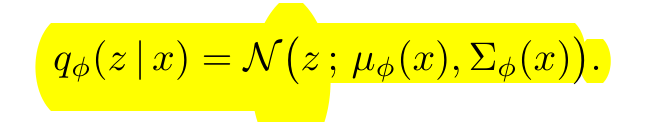 

Here, assume the $\Sigma_{\phi}$ is a diagnal matrix, so `logvar` is a vector containing the diagonal elements of $\Sigma_{\phi}$. Elements can be negative since the log operation

In [5]:
class VAE(AbstractAutoencoder):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )
        self.mu_phi = nn.Linear(256, latent_dim)
        self.logvar = nn.Linear(256, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 300),
            nn.ReLU(),
            nn.Linear(300, 600),
            nn.ReLU(),
            nn.Linear(600, input_dim),
            nn.Sigmoid()
        )  # for mu theta

    def encode(self, X):
        h = self.encoder(X)
        return self.mu_phi(h), self.logvar(h)

    def reparametrize(self, mu_phi, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std).detach().to(device)
        return mu_phi + eps * std

    def decode(self, X):
        return self.decoder(X)

    def forward(self, X):
        mu_phi, logvar = self.encode(X)
        z = self.reparametrize(mu_phi, logvar)
        return self.decode(z), mu_phi, logvar

    def loss_fn(self, X, Y, mu_phi, logvar):
        prior_matching = torch.sum(mu_phi ** 2 + torch.exp(logvar) - logvar)
        reconstruction = torch.sum((X - Y) ** 2)
        return prior_matching + reconstruction

In [6]:
from torchinfo import summary

model = VAE(input_dim=784, latent_dim=32).to(device)
print(summary(model, (56, 784)))
print(model)

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [56, 784]                 --
├─Sequential: 1-1                        [56, 256]                 --
│    └─Linear: 2-1                       [56, 512]                 401,920
│    └─ReLU: 2-2                         [56, 512]                 --
│    └─Linear: 2-3                       [56, 256]                 131,328
│    └─ReLU: 2-4                         [56, 256]                 --
├─Linear: 1-2                            [56, 32]                  8,224
├─Linear: 1-3                            [56, 32]                  8,224
├─Sequential: 1-4                        [56, 784]                 --
│    └─Linear: 2-5                       [56, 300]                 9,900
│    └─ReLU: 2-6                         [56, 300]                 --
│    └─Linear: 2-7                       [56, 600]                 180,600
│    └─ReLU: 2-8                         [56, 600]           

In [8]:
def train(model: VAE, loss_fn, optimizer, train_loader, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        for batch in (pbar := tqdm(train_loader, desc=f"Train epoch {epoch}/{num_epochs}")):
            X, _ = batch
            X = X.to(device)
            optimizer.zero_grad()
            mu_theta, mu_phi, logvar = model(X)
            loss = model.loss_fn(X, mu_theta, mu_phi, logvar)
            loss.backward()
            optimizer.step()
            pbar.set_postfix({"loss": loss.item()})
            
        model.eval()
        with torch.no_grad():
            for batch in (pbar := tqdm(test_loader, desc=f"Test epoch {epoch}/{num_epochs}")):
                X, _ = batch
                X = X.to(device)
                mu_theta, mu_phi, logvar = model(X)
                loss = model.loss_fn(X, mu_theta, mu_phi, logvar)
                pbar.set_postfix({"loss": loss.item()})

model = VAE(input_dim=784, latent_dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, model.loss_fn, optimizer, train_loader, num_epochs=5)

Test epoch 4/5: 100%|██████████| 313/313 [00:01<00:00, 238.07it/s, loss=1.14e+3]


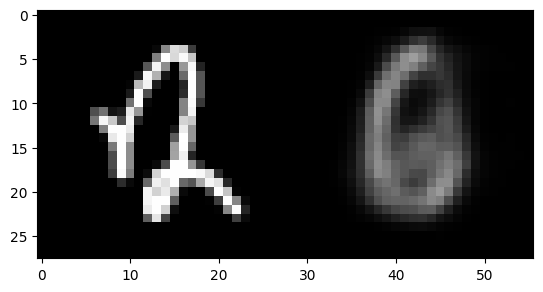

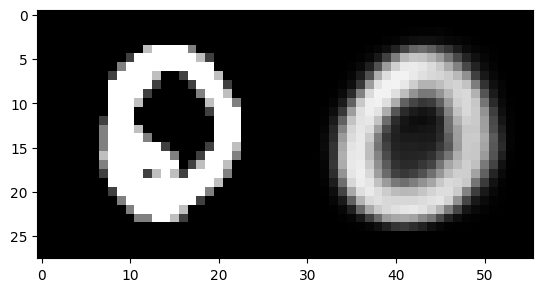

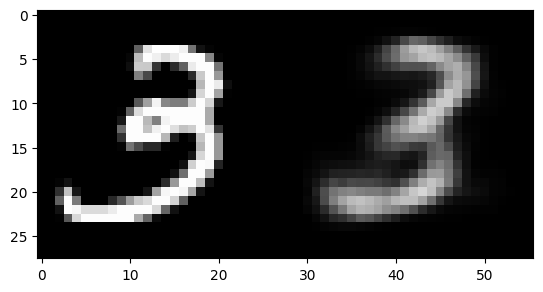

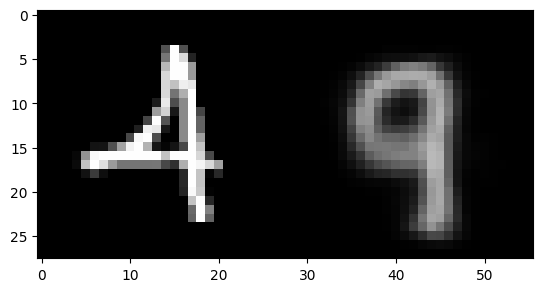

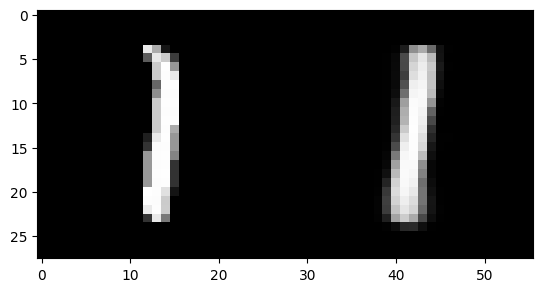

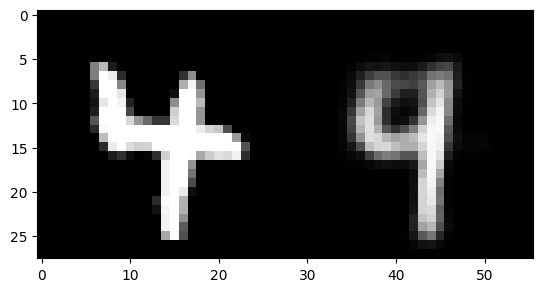

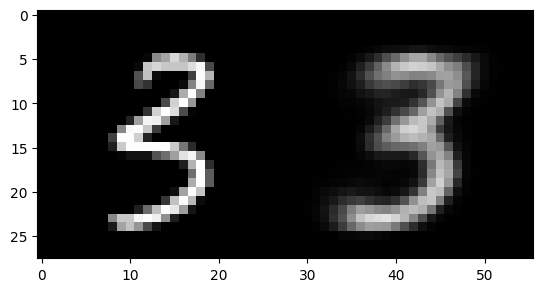

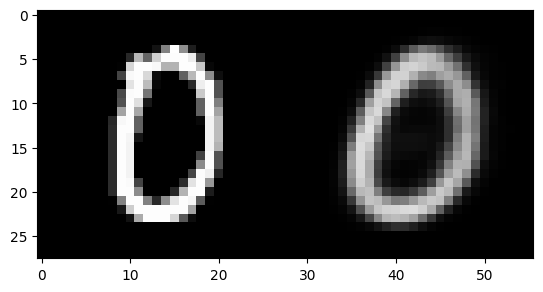

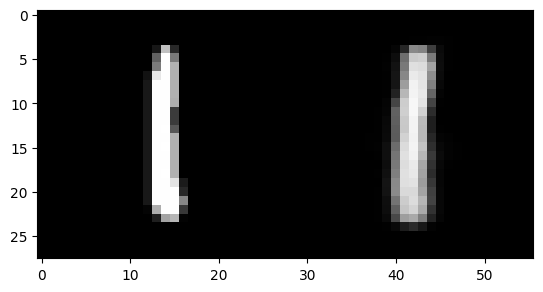

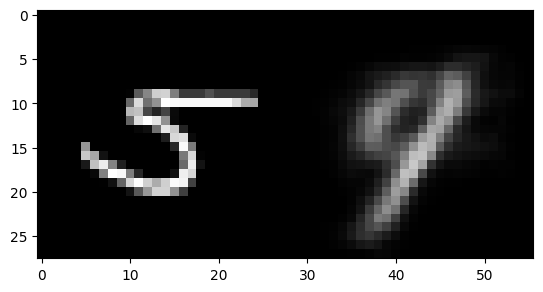

In [9]:
# Inference use the model
def reconstruct(model, test_loader, n=10):
    model.eval()
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs, _, _ = model(images)
            for i in range(n):
                img = images[i].view(28, 28).cpu().numpy()
                out = outputs[i].view(28, 28).cpu().numpy()
                plt.imshow(np.hstack([img, out]), cmap='gray')
                plt.show()
            break

reconstruct(model, test_loader, n=10)